# VRCC - Circular plots per subject

*Pawel Motyka, Felix Klotzsche, Aleksander Molak*


pmotyka@psych.pan.pl, 
klotzsche@cbs.mpg.de, 
alex@lespire.io

___
Visualization of the circular analysis of the cardiac eefects on the distance error.
___ 

In [1]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
lowess = sm.nonparametric.lowess

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from pygam import LinearGAM, s, f
from pygam.datasets import mcycle

from tqdm import tqdm

In [2]:
data = pd.read_csv(r'../../../../Data/VRTask/VRCC_data_consolidated-2023-08-10') # NOTE: Errors are encoded in in meters

In [3]:
data.shape, data.ID.unique().shape

((28933, 45), (41,))

In [4]:
colors = [
    '#0c4271',#'#bf1363'
    '#ba135d',#'#03256c',
    'gray'
]

# Pawel's colors
colors = [
    '#002992',
    '#B21f00',
    'black'
]

## Helpers

In [5]:
def get_circular_components(x, period):
    """
    Takes a 1D circular variable and returns it's 2D embedding on a unit circle
    where the cos component represents Cartesian x-coordianate and sin component represents Cartesian y-coordinate.
    """
    x = np.array(x)
    omega = (2 * np.pi) / period
    cos_component = np.cos(x * omega)
    sin_component = np.sin(x * omega)
    return cos_component, sin_component


def get_positions_and_errors(data, scaling_factor):
    """
    Takes data and sclaing factor and returns position and error arrays for each condition.
    """
    SCALING_FACTOR = scaling_factor

    # Threat = 0
    positions_threat_0 = data[data.FearObject == 0].relPosRRrad.values 
    errors_threat_0 = data[data.FearObject == 0].DistanceError.values * SCALING_FACTOR

    # Threat = 1
    positions_threat_1 = data[data.FearObject == 1].relPosRRrad.values 
    errors_threat_1 = data[data.FearObject == 1].DistanceError.values * SCALING_FACTOR
    
    return {
        'threat_0': {
            'position': positions_threat_0,
            'error': errors_threat_0
        },
        'threat_1': {
            'position': positions_threat_1,
            'error': errors_threat_1
        }
    }


def fake_cycle(pos_and_error, n_cycles):
    """
    Fakes a cyclical nature of the data (repeats the same data n_cycle times) to get correct 
    estimations for series ends
    """
    POSITION_FACTOR = 2*np.pi - 2.6645352591003757e-15 # Numerical adjustment
    
    # Unpack
    positions_threat_0 = pos_and_error['threat_0']['position']
    positions_threat_1 = pos_and_error['threat_1']['position']
    
    errors_threat_0 = pos_and_error['threat_0']['error']
    errors_threat_1 = pos_and_error['threat_1']['error']
    

    positions_threat_0_mult = list(positions_threat_0 - POSITION_FACTOR) + \
                              list(positions_threat_0) + \
                              list(positions_threat_0 + POSITION_FACTOR)
    errors_threat_0_mult = np.array(list(errors_threat_0) * n_cycles)

    positions_threat_1_mult = list(positions_threat_1 - POSITION_FACTOR) + \
                              list(positions_threat_1) + \
                              list(positions_threat_1 + POSITION_FACTOR)
    errors_threat_1_mult = np.array(list(errors_threat_1) * n_cycles)
    
    return {
        'threat_0': {
            'position': positions_threat_0_mult,
            'error': errors_threat_0_mult
        },
        'threat_1': {
            'position': positions_threat_1_mult,
            'error': errors_threat_1_mult
        }
    }


def get_gam_estimates(X, y, n_splines=25, n_points=2000, return_intervals=True):
    
    X = np.array(X)[:, np.newaxis]
    y = np.array(y)
    
    gam = LinearGAM(n_splines=n_splines).gridsearch(X, y)
#     XX = gam.generate_X_grid(term=0, n=n_points)
    XX = np.linspace(0, 2*np.pi - 1e-12, 1000)[:, np.newaxis]

    
    if return_intervals:
        return XX, gam.predict(XX), gam.prediction_intervals(XX, width=.95)
    else:
        return XX, gam.predict(XX), None
    

def get_gam_positions(pos_and_error, n_splines, return_intervals=True, return_original_slice=True):
    # Compute GAMs
    N_SPLINES = n_splines
    
    # Unpack
    positions_threat_0_mult = pos_and_error['threat_0']['position']
    positions_threat_1_mult = pos_and_error['threat_1']['position']
    
    errors_threat_0_mult = pos_and_error['threat_0']['error']
    errors_threat_1_mult = pos_and_error['threat_1']['error']
    
    # Compute GAM estimates
    X_gam_0, y_gam_0, Xy_gam_0_int = get_gam_estimates(
        positions_threat_0_mult, 
        errors_threat_0_mult, 
        n_splines=N_SPLINES,
        return_intervals=return_intervals
    )
    
    X_gam_1, y_gam_1, Xy_gam_1_int = get_gam_estimates(
        positions_threat_1_mult, 
        errors_threat_1_mult, 
        n_splines=N_SPLINES,
        return_intervals=return_intervals
    )
    
    if return_original_slice:
        
        if return_intervals:
            
            # Get back the original shape => conf. ints
            _, y_gam_0_lower = get_original_slice(X_gam_0, Xy_gam_0_int[:, 0])
            _, y_gam_0_upper = get_original_slice(X_gam_0, Xy_gam_0_int[:, 1])

            _, y_gam_1_lower = get_original_slice(X_gam_1, Xy_gam_1_int[:, 0])
            _, y_gam_1_upper = get_original_slice(X_gam_1, Xy_gam_1_int[:, 1])
            
            # Stack conf ints
            Xy_gam_0_int = np.hstack(
                [
                    y_gam_0_lower[:, np.newaxis],
                    y_gam_0_upper[:, np.newaxis]
                ]
            )
            
            Xy_gam_1_int = np.hstack(
                [
                    y_gam_1_lower[:, np.newaxis],
                    y_gam_1_upper[:, np.newaxis]
                ]
            )

        # Get back the original shape
        X_gam_0, y_gam_0 = get_original_slice(X_gam_0, y_gam_0)
        X_gam_1, y_gam_1 = get_original_slice(X_gam_1, y_gam_1)
    
    return {
        'threat_0': {
            'position': X_gam_0,
            'error': y_gam_0,
            'conf_ints': Xy_gam_0_int
        },
        'threat_1': {
            'position': X_gam_1,
            'error': y_gam_1,
            'conf_ints': Xy_gam_1_int 
        }
    }
    

def get_original_slice(X, y, bounds=(0, 2*np.pi)):
    X = X.squeeze()
    mask = (X >= bounds[0]) & (X <= bounds[1])
    return X[mask], y[mask]

def get_error_pos(x, y, errors):
    
    errors = np.array(errors)
    
    matrix = np.stack([x, y], axis=1)
    
    signs = np.sign(matrix)

    abs_pos = np.abs(matrix) * (1 + errors[:, np.newaxis])
    signed_pos = abs_pos * signs
    return signed_pos[:, 0], signed_pos[:, 1]


def compute_circular_embeddings(X, y, scaling_factor=1):
    """
    Computes circular embeddings
    """
    SCALING_FACTOR = scaling_factor

    #------------------------------

    # Threat = 0 
    y_, x_ = get_circular_components(X, period=2*np.pi)
    x_pos_, y_pos_ = get_error_pos(x_, y_, y*SCALING_FACTOR)
    
    return x_pos_, y_pos_

## Get plots

In [6]:
N_SPLINES = [500]#[100, 200, 300, 500]

gams = {}

# Iterate over n_splines
for n_splines in N_SPLINES:
    
    print(f'Computations for {n_splines} splines.')
    
    gams[n_splines] = {}

    # Iterate over subjects
    for subject in tqdm(data.ID.unique()):
        
        # Select subject
        data_local = data[data.ID == subject]
        
        # Get positions and errors
        pos_and_err = get_positions_and_errors(data_local, scaling_factor=1)
        
        # Get fake circularity
        pos_and_err = fake_cycle(pos_and_err, n_cycles=3)
    
        # Compute GAM estimates
        gam_pos_and_err = get_gam_positions(
            pos_and_error=pos_and_err, 
            n_splines=n_splines,
            return_original_slice=True
        )
        
        # Store
        gams[n_splines][subject] = gam_pos_and_err
        

Computations for 500 splines.


  0%|          | 0/41 [00:00<?, ?it/s]  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


  9% (1 of 11) |##                       | Elapsed Time: 0:00:01 ETA:   0:00:13
 18% (2 of 11) |####                     | Elapsed Time: 0:00:02 ETA:   0:00:12
 27% (3 of 11) |######                   | Elapsed Time: 0:00:03 ETA:   0:00:10
 36% (4 of 11) |#########                | Elapsed Time: 0:00:05 ETA:   0:00:09
 45% (5 of 11) |###########              | Elapsed Time: 0:00:07 ETA:   0:00:12
 54% (6 of 11) |#############            | Elapsed Time: 0:00:08 ETA:   0:00:08
 63% (7 of 11) |###############          | Elapsed Time: 0:00:10 ETA:   0:00:05
 72% (8 of 11) |##################       | Elapsed Time: 0:00:11 ETA:   0:00:03
 81% (9 of 11) |####################     | Elapsed Time: 0:00:12 ETA:   0:00:02
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:13 ETA:   0:00:01
100% (11 of 11) |########################| Elapsed Time: 0:00:14 Time:  0:00:14
  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                      

In [7]:
# Collect all GAMs 
aggregated = {}

for n_splines in gams.keys():
    print(f'Processing the model for {n_splines}')
    
    aggregated[n_splines] = {
        'threat_0': [],
        'threat_1': []
    }
    
    for subject in gams[n_splines].keys():
        aggregated[n_splines]['threat_0'].append(gams[n_splines][subject]['threat_0']['error'])
        aggregated[n_splines]['threat_1'].append(gams[n_splines][subject]['threat_1']['error'])
        
        
# Get grand means
grand_means = {}

for n_splines in aggregated.keys():
    grand_means[n_splines] = {}
    grand_means[n_splines]['threat_0'] = np.array(aggregated[n_splines]['threat_0']).mean(axis=0)
    grand_means[n_splines]['threat_1'] = np.array(aggregated[n_splines]['threat_1']).mean(axis=0)
    

Processing the model for 500


In [8]:
(np.abs(grand_means[500]['threat_1']) > .025).sum()

55

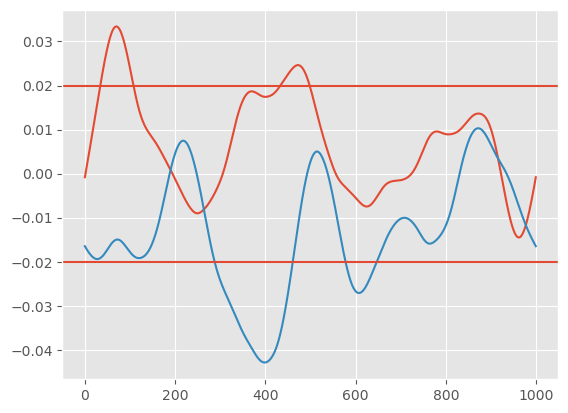

In [9]:
SF_ = 1
plt.plot(grand_means[500]['threat_1']*SF_)
plt.plot(grand_means[500]['threat_0']*SF_)
plt.axhline(.02*SF_)
plt.axhline(-.02*SF_)

In [10]:
# Embedd grand means
SCALING_FACTOR = 1.5
REFERENCE_LINE = .05  # In meters

embedded_components = {}

gam_position = gams[500]['S01']['threat_0']['position'] # Any subject will do - all are the same

for n_splines in grand_means.keys():
    
    embedded_components[n_splines] = {}
    
    for cond in grand_means[n_splines].keys():

        x_pos, y_pos = compute_circular_embeddings(
            X=gam_position,
            y=grand_means[n_splines][cond],
            scaling_factor=SCALING_FACTOR
        )
        
        embedded_components[n_splines][cond] = {
            'x_pos': x_pos,
            'y_pos': y_pos
        }


# Generate error lines
ref_positive = np.ones_like(gam_position) * REFERENCE_LINE
ref_negative = np.ones_like(gam_position) * -REFERENCE_LINE

# Embed error lines
ref_positive_x_pos, ref_positive_y_pos = compute_circular_embeddings(
    X=gam_position,
    y=ref_positive,
    scaling_factor=SCALING_FACTOR
)

ref_negative_x_pos, ref_negative_y_pos = compute_circular_embeddings(
    X=gam_position,
    y=ref_negative,
    scaling_factor=SCALING_FACTOR
)

embedded_reference_lines = {
    'negative': {
        'x_pos': ref_positive_x_pos,
        'y_pos': ref_positive_y_pos
    },
    'positive': {
        'x_pos': ref_negative_x_pos,
        'y_pos': ref_negative_y_pos
    }
}

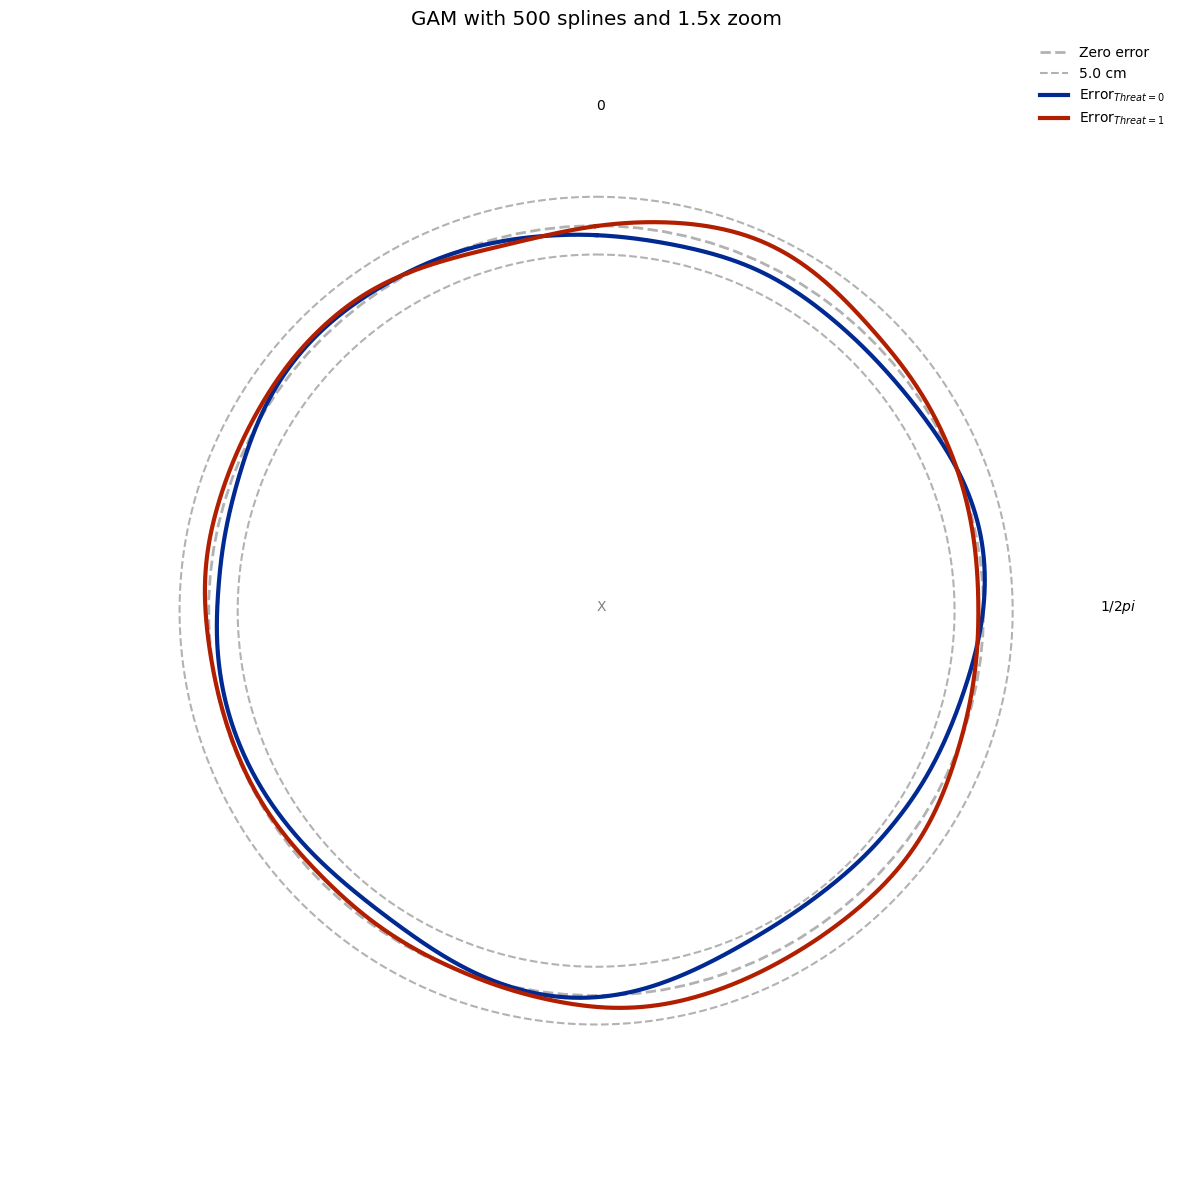

In [47]:
# Plot embeddings
N_SPLINES = 500

# Unpack variables
x_pos_0 = embedded_components[N_SPLINES]['threat_0']['x_pos']
x_pos_1 = embedded_components[N_SPLINES]['threat_1']['x_pos']
y_pos_0 = embedded_components[N_SPLINES]['threat_0']['y_pos']
y_pos_1 = embedded_components[N_SPLINES]['threat_1']['y_pos']

ref_line_positive_x_pos = embedded_reference_lines['positive']['x_pos']
ref_line_positive_y_pos = embedded_reference_lines['positive']['y_pos']
ref_line_negative_x_pos = embedded_reference_lines['negative']['x_pos']
ref_line_negative_y_pos = embedded_reference_lines['negative']['y_pos']

# Setup
POINT_SIZE = .2
POINT_ALPHA = .5

LOESS_SIZE = 3
LOESS_ALPHA = .4

ERROR_LW = .15
ERROR_COLOR = '#47454d'

# Unit circle components
t = np.linspace(0, 2*np.pi, 100)

# Define figure
plt.figure(figsize=(15, 15))

# Plot unit circle
plt.plot(np.cos(t), np.sin(t), color='black', linewidth=LOESS_SIZE - 1, label='Zero error', alpha=.3, ls='--')

# Plot GAM
plt.plot(x_pos_0, y_pos_0, color=colors[0], alpha=1, lw=3)
plt.plot(x_pos_1, y_pos_1, color=colors[1], alpha=1, lw=3)

# Plot reference lines
plt.plot(
    ref_line_negative_x_pos, 
    ref_line_negative_y_pos, 
    color=colors[2], 
    alpha=.3, 
    linestyle='dashed',
    label=f'{100*REFERENCE_LINE} cm')

plt.plot(
    ref_line_positive_x_pos, 
    ref_line_positive_y_pos, 
    color=colors[2], 
    alpha=.3, 
    linestyle='dashed')

# plt.plot(x_pos_1_lower, y_pos_1_lower, color=colors[1], alpha=.3, linestyle='dashed')
# plt.plot(x_pos_1_upper, y_pos_1_upper, color=colors[1], alpha=.3, linestyle='dashed')

plt.plot([900, 900],
         color=colors[0],
         lw=3,
         alpha=1, #LOESS_ALPHA + .3,
         label = 'Error$_{Threat = 0}$')


plt.plot([900, 900],
         color=colors[1],
         lw=3,
         alpha=1, #LOESS_ALPHA + .3,
         label = 'Error$_{Threat = 1}$')

# Add angles
plt.text(1.3, 0, '$1/2pi$')
plt.text(-.0, 1.3, '$0$')

# Add observer
plt.text(0, 0, 'X', alpha=.5)

# Set axis limits
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

# Axis off
# plt.axis('off')
plt.xticks([], [])
plt.yticks([], [])

plt.title(f'GAM with {N_SPLINES} splines and {SCALING_FACTOR}x zoom')

# Background
plt.gca().set_facecolor('white')

plt.legend(facecolor='white', edgecolor='white')
plt.show()

## Individual lines

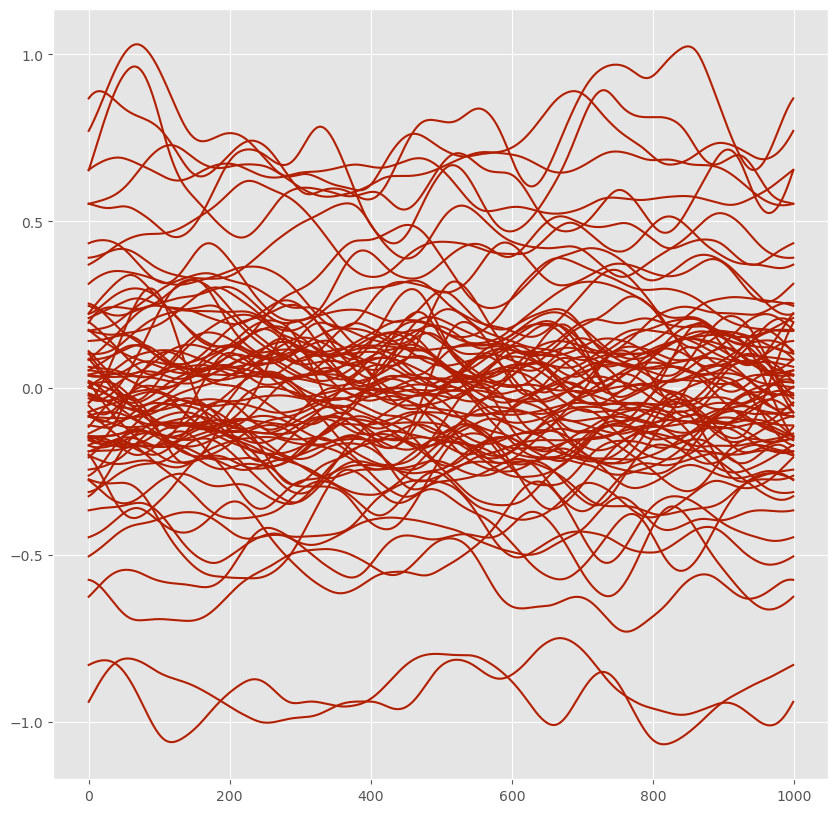

In [11]:
N_SPLINES = 500

plt.figure(figsize=(10, 10))

for cond in aggregated[N_SPLINES].keys():
    
    if cond == 'threat_O':
        COLOR = colors[0]
        LABEL = '$Error_{Threat=0}$'
    else:
        COLOR = colors[1]
        LABEL = '$Error_{Threat=1}$'
        
    for subject_vals in aggregated[N_SPLINES][cond]:
        plt.plot(subject_vals, c=COLOR)
        